# Mask R-CNN - Train on Shapes Dataset

### Notes from implementation

This notebook shows how to train Mask R-CNN on your own dataset. To keep things simple we use a synthetic dataset of shapes (squares, triangles, and circles) which enables fast training. You'd still need a GPU, though, because the network backbone is a Resnet101, which would be too slow to train on a CPU. On a GPU, you can start to get okay-ish results in a few minutes, and good results in less than an hour.

The code of the *Shapes* dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size, so we pick a small image size to train faster. 


### Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the shapes dataset, `load_shapes()`, and override the following methods:

* load_image()
* load_mask()
* image_reference()

In [3]:
# from jupyterthemes import jtplot

# choose which theme to inherit plotting style from
# onedork | grade3 | oceans16 | chesterish | monokai | solarizedl | solarizedd
# jtplot.style(theme='onedork')


In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import tensorflow as tf
import keras
import pprint
import keras.backend as KB
sys.path.append('../')

import mrcnn.model     as modellib
import mrcnn.visualize as visualize
import mrcnn.shapes    as shapes
from mrcnn.config      import Config
from mrcnn.model       import log
from mrcnn.dataset     import Dataset 
# from mrcnn.pc_layer    import PCTensor
from mrcnn.pc_layer   import PCNLayer

# Root directory of the project
ROOT_DIR = os.getcwd()
MODEL_PATH = 'E:\Models'
# Directory to save logs and trained model
MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
# Path to COCO trained weights
COCO_MODEL_PATH   = os.path.join(MODEL_PATH, "mask_rcnn_coco.h5")
RESNET_MODEL_PATH = os.path.join(MODEL_PATH, "resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5")

print("Tensorflow Version: {}   Keras Version : {} ".format(tf.__version__,keras.__version__))
pp = pprint.PrettyPrinter(indent=2, width=100)
np.set_printoptions(linewidth=100)

# Build configuration object -----------------------------------------------
config = shapes.ShapesConfig()
config.BATCH_SIZE      = 2                    #Batch size is 2 (# GPUs * images/GPU).
config.IMAGES_PER_GPU  = 2
config.STEPS_PER_EPOCH = 7
# config.IMAGES_PER_GPU  = 1
config.display() 

# Build shape dataset        -----------------------------------------------

from mrcnn.datagen import data_generator, load_image_gt

# Training dataset
# generate 500 shapes 
dataset_train = shapes.ShapesDataset()
dataset_train.load_shapes(500, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_train.prepare()

# Validation dataset
dataset_val = shapes.ShapesDataset()
dataset_val.load_shapes(50, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1])
dataset_val.prepare()

# Load and display random samples
# image_ids = np.random.choice(dataset_train.image_ids, 3)
# for image_id in [3]:
#     image = dataset_train.load_image(image_id)
#     mask, class_ids = dataset_train.load_mask(image_id)
#     visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)


D:\Program Files\Anaconda3\envs\TF_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Tensorflow Version: 1.4.0   Keras Version : 2.1.3 

Configurations:
BACKBONE_SHAPES                [[32 32]
 [16 16]
 [ 8  8]
 [ 4  4]
 [ 2  2]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  128
IMAGE_MIN_DIM                  128
IMAGE_PADDING                  True
IMAGE_SHAPE                    [128 128   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [123.7 116.8 103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           shapes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE  

## Create Model

In [4]:
# import importlib
# importlib.reload(model)
# Create model in training mode
# MODEL_DIR = os.path.join(MODEL_PATH, "mrcnn_logs")
import  gc
# del history
try :
    del model
except: 
    pass
 
gc.collect()

model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

#model.keras_model.summary(line_length = 120)

# print(MODEL_PATH)
print(COCO_MODEL_PATH)
# print(RESNET_MODEL_PATH)
print(' Checkpoint folder: ', MODEL_DIR)
print(model.find_last())

# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
#     loc=model.load_weights(model.get_imagenet_weights(), by_name=True)
    loc=model.load_weights(RESNET_MODEL_PATH, by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    
    # See README for instructions to download the COCO weights
    loc=model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    loc= model.load_weights(model.find_last()[1], by_name=True)
print('>>> Load weights complete')

set_log_dir: Checkpoint path set to : E:\Models\mrcnn_logs\shapes20180401T1447\mask_rcnn_shapes_{epoch:04d}.h5
 IMAGE SHAPE is : 128    128
<class 'list'>
Tensor("rpn_class_logits/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class_logits/concat:0
Tensor("rpn_class/concat:0", shape=(?, ?, 2), dtype=float32) rpn_class/concat:0
Tensor("rpn_bbox/concat:0", shape=(?, ?, 4), dtype=float32) rpn_bbox/concat:0
Proposal Layer init complete. Size of anchors:  (4092, 4)
>>> Detection Target Layer : initialization
>>> Detection Target Layer : call 
>>> detection_targets_graph 
     overlaps_graph: shape of boxes1 before reshape:  (?, ?)
     overlaps_graph: shape of boxes2 before reshape:  (?, 4)
     overlaps_graph: shape of boxes1 after reshape:  (?, 4)
     overlaps_graph: shape of boxes2 after reshape:  (?, 4)
     overlaps_graph: shape of b1_y1 after reshape:  (?, 1)
Shape of overlaps Tensor("proposal_targets/Shape_5:0", shape=(2,), dtype=int32)
>>> detection_targets_graph 
     overlaps_gra

In [5]:
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=model.config.BATCH_SIZE,
                                 augment = False)
val_generator = data_generator(dataset_val, model.config, shuffle=True, 
                                batch_size=model.config.BATCH_SIZE,
                                augment=False)

## Process outside of training 

In [6]:
model.compile_only(learning_rate=config.LEARNING_RATE, layers='heads')
# print(KB.eval(KB.learning_phase()))
KB.set_learning_phase(1)
print(' Learning phase values is L ' ,KB.learning_phase())
mm = model.keras_model
print('\n Metrics (_get_deduped_metrics_names():) ') 
pp.pprint(mm._get_deduped_metrics_names())
print('\n Outputs: ') 
pp.pprint(mm.outputs)
# pp.pprint(mm.fit_generator.__dict__['__wrapped__'])

print('\n Losses (model.metrics_names): ') 
# pp.pprint(mm.losses)
pp.pprint(mm.metrics_names)



Compile with learing rate; 0.001 Learning Moementum: 0.9 
Checkpoint Folder:  E:\Models\mrcnn_logs\shapes20180313T1856\mask_rcnn_shapes_{epoch:04d}.h5 

Selecting layers to train
Layer    Layer Name               Layer Type
174  fpn_c5p5               (Conv2D)
176  fpn_c4p4               (Conv2D)
179  fpn_c3p3               (Conv2D)
182  fpn_c2p2               (Conv2D)
184  fpn_p5                 (Conv2D)
185  fpn_p2                 (Conv2D)
186  fpn_p3                 (Conv2D)
187  fpn_p4                 (Conv2D)
In model:  rpn_model
      1  rpn_conv_shared        (Conv2D)
      2  rpn_class_raw          (Conv2D)
      4  rpn_bbox_pred          (Conv2D)
199  mrcnn_mask_conv1       (TimeDistributed)
200  mrcnn_mask_bn1         (TimeDistributed)
202  mrcnn_mask_conv2       (TimeDistributed)
204  mrcnn_mask_bn2         (TimeDistributed)
205  mrcnn_class_conv1      (TimeDistributed)
207  mrcnn_class_bn1        (TimeDistributed)
208  mrcnn_mask_conv3       (TimeDistributed)
210  mrcnn_mas

### Get next shapes from generator and display loaded shapes

In [11]:
train_batch_x, train_batch_y = next(train_generator)

Load Mask information (shape, (color rgb), (x_ctr, y_ctr, size) ): 
[('circle', (116, 190, 144), (23, 43, 23)), ('triangle', (5, 98, 31), (83, 32, 32))]
 Shapes obj mask shape is : (128, 128, 2)
Load Mask information (shape, (color rgb), (x_ctr, y_ctr, size) ): 
[ ('triangle', (34, 59, 29), (41, 52, 22)),
  ('triangle', (202, 112, 49), (63, 102, 20)),
  ('square', (236, 140, 3), (60, 80, 31))]
 Shapes obj mask shape is : (128, 128, 3)


Image id:  438
Load Mask information (shape, (color rgb), (x_ctr, y_ctr, size) ): 
[('circle', (116, 190, 144), (23, 43, 23)), ('triangle', (5, 98, 31), (83, 32, 32))]
 Shapes obj mask shape is : (128, 128, 2)


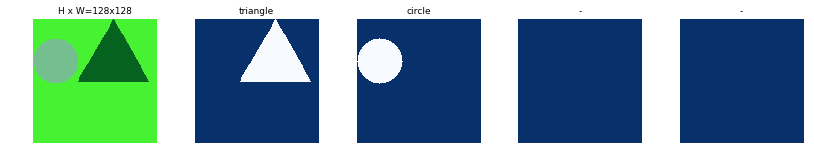

Image id:  262
Load Mask information (shape, (color rgb), (x_ctr, y_ctr, size) ): 
[ ('triangle', (34, 59, 29), (41, 52, 22)),
  ('triangle', (202, 112, 49), (63, 102, 20)),
  ('square', (236, 140, 3), (60, 80, 31))]
 Shapes obj mask shape is : (128, 128, 3)


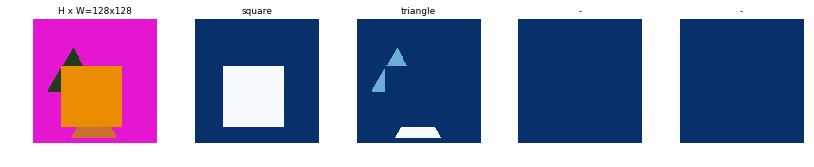

In [12]:
imgmeta_idx = mm.input_names.index('input_image_meta')
img_meta    = train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

#### Plot mask in string format

In [36]:
# np.set_printoptions(threshold=99999, linewidth=2000)
# print(np.array2string(mask[...,0],max_line_width=2000,separator=''))


In [ ]:
outmask0 = layers_out[14][0,:,:,:,1] ##  mrcnn_mask
np.max(outmask0)

## Fine Tuning
Fine tune all layers

In [ ]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=211,
            layers="all")

## Save 

In [ ]:
# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(ShapesConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)

original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_bbox)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id,
                         r["rois"], r["class_ids"], r["scores"])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

### Training head using  Keras.model.fit_generator()

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.

model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=69, 
            layers='heads')

### Training heads using train_on_batch()

We need to use this method for the time being as the fit generator does not have provide EASY access to the output in Keras call backs. By training in batches, we pass a batch through the network, pick up the generated RoI detections and bounding boxes and generate our semantic / gaussian tensors ...



In [ ]:
model.train_in_batches(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs_to_run = 2,
            layers='heads')

### Simulate one training iteration

In [ ]:
from mrcnn.datagen import data_generator, load_image_gt
np.set_printoptions(linewidth=100)
learning_rate=model.config.LEARNING_RATE
epochs_to_run = 2
layers='heads'
batch_size = 0
steps_per_epoch = 0
# assert self.mode == "training", "Create model in training mode."
# Pre-defined layer regular expressions
layer_regex = {
    # all layers but the backbone
    "heads": r"(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # From a specific Resnet stage and up
    "3+": r"(res3.*)|(bn3.*)|(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "4+": r"(res4.*)|(bn4.*)|(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    "5+": r"(res5.*)|(bn5.*)|(mrcnn\_.*)|(rpn\_.*)|(fpn\_.*)",
    # All layers
    "all": ".*",
}

if layers in layer_regex.keys():
    layers = layer_regex[layers]
if batch_size == 0 :
    batch_size = model.config.BATCH_SIZE            
if steps_per_epoch == 0:
    steps_per_epoch = model.config.STEPS_PER_EPOCH

# Data generators
train_generator = data_generator(dataset_train, model.config, shuffle=True,
                                 batch_size=batch_size)
val_generator   = data_generator(dataset_val, model.config, shuffle=True,
                                 batch_size=batch_size,
                                 augment=False)

# Train
log("Last epoch completed : {} ".format(model.epoch))
log("Starting from epoch {} for {} epochs. LR={}".format(model.epoch, epochs_to_run, learning_rate))
log("Steps per epoch:    {} ".format(steps_per_epoch))
log("Batchsize      :    {} ".format(batch_size))
log("Checkpoint Folder:  {} ".format(model.checkpoint_path))
epochs = model.epoch + epochs_to_run

from tensorflow.python.platform import gfile
if not gfile.IsDirectory(model.log_dir):
    log('Creating checkpoint folder')
    gfile.MakeDirs(model.log_dir)
else:
    log('Checkpoint folder already exists')

model.set_trainable(layers)            
model.compile(learning_rate, model.config.LEARNING_MOMENTUM)        

out_labels = model.keras_model._get_deduped_metrics_names()
callback_metrics = out_labels + ['val_' + n for n in out_labels]

progbar = keras.callbacks.ProgbarLogger(count_mode='steps')
progbar.set_model(model.keras_model)
progbar.set_params({
    'epochs': epochs,
    'steps': steps_per_epoch,
    'verbose': 1,
    'do_validation': False,
    'metrics': callback_metrics,
})

progbar.set_model(model.keras_model) 

chkpoint = keras.callbacks.ModelCheckpoint(model.checkpoint_path, 
                                           monitor='loss', verbose=1, save_best_only = True, save_weights_only=True)
chkpoint.set_model(model.keras_model)

progbar.on_train_begin()
epoch_idx = model.epoch

In [ ]:
if epoch_idx >= epochs:
    print('Final epoch {} has already completed - Training will not proceed'.format(epochs))

# while epoch_idx < epochs :
progbar.on_epoch_begin(epoch_idx)
steps_index = 0
# for steps_index in range(steps_per_epoch):

batch_logs = {}
print(' self.epoch {}   epochs {}  step {} '.format(model.epoch, epochs, steps_index))
batch_logs['batch'] = steps_index
batch_logs['size']  = batch_size
progbar.on_batch_begin(steps_index, batch_logs)

In [ ]:
train_batch_x, train_batch_y = next(train_generator)

In [ ]:
imgmeta_idx= model.keras_model.input_names.index('input_image_meta')
img_meta  =  train_batch_x[imgmeta_idx]

image_id = img_meta[0,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

image_id = img_meta[1,0]
print('Image id: ',image_id)
image = dataset_train.load_image(image_id)
mask, class_ids = dataset_train.load_mask(image_id)
visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

outs = model.keras_model.train_on_batch(train_batch_x, train_batch_y)

### Simulate one training iteration - 4

In [ ]:
if not isinstance(outs, list):
    outs = [outs]
for l, o in zip(out_labels, outs):
    batch_logs[l] = o

    progbar.on_batch_end(steps_index, batch_logs)

        # print(outs)
    progbar.on_epoch_end(epoch_idx, {})
    # if (epoch_idx % 10) == 0:
    chkpoint.on_epoch_end(epoch_idx  , batch_logs)
    epoch_idx += 1

# if epoch_idx != self.epoch:
# chkpoint.on_epoch_end(epoch_idx -1, batch_logs)
model.epoch = max(epoch_idx - 1, epochs)

print('Final : self.epoch {}   epochs {}'.format(model.epoch, epochs))
# end if (else)